In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_optimization_lib as gmm_optim_lib
from bnpgmm_runjingdev import gmm_posterior_quantities_lib

# BNP libraries
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev import result_loading_utils, influence_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

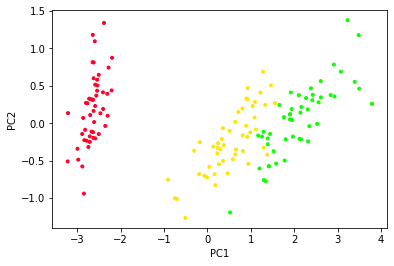

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# file paths

In [4]:
out_folder = '../fits/'
out_filename = 'iris_fit'

In [5]:
alpha0 = 6.0

# Load initial fit

In [6]:
init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
print(init_fit_file)

../fits/iris_fit_alpha6.0.npz


In [7]:
vb_opt_dict, vb_params_paragami, init_fit_meta_data = \
            paragami.load_folded(init_fit_file)
        
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)    

In [8]:
k_approx = vb_opt_dict['cluster_params']['centroids'].shape[0]
print(k_approx)

15


### Load other meta data

In [9]:
# gauss-hermite parameters
gh_deg = int(init_fit_meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

# set initial alpha
assert alpha0 == init_fit_meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

{'dp_prior_alpha': 6.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


In [10]:
# the objective 
kl = gmm_lib.get_kl(iris_obs, vb_opt_dict, prior_params_dict, gh_loc, gh_weights)

In [11]:
kl - init_fit_meta_data['final_kl']

DeviceArray(0., dtype=float64)

### Optimal ez

In [12]:
e_z_opt = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_opt_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)

### Check results

In [13]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[np.unique(bnp_clusters), :], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


In [14]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_opt_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_opt_dict['cluster_params']['cluster_info']))

In [15]:
bnp_centroids_pc.shape

(15, 4)

### Plot centroids

Text(0, 0.5, 'PC2')

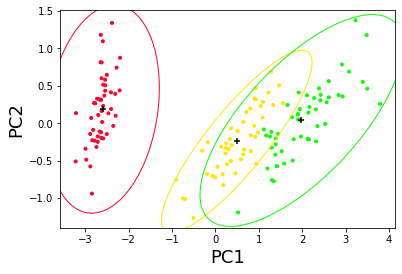

In [16]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [17]:
def get_e_num_obs_per_cluster(vb_params_dict): 
    ez = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_params_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)
    return ez.sum(0)

In [18]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt_dict)
mixture_weights = gmm_posterior_quantities_lib.get_e_mixture_weights_from_vb_dict(vb_opt_dict, gh_loc, gh_weights)

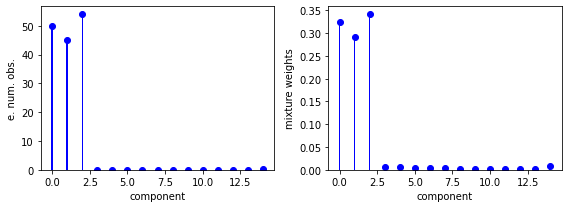

In [19]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()

# Define sensitivity class

In [20]:
def objective_fun(vb_params_free, epsilon): 
    
    # NOTE! epsilon doesn't actual enter 
    # into this function. 
    
    # since the initial fit is at epsilon = 0, 
    # we just return the actual KL
    
    # we really just need the hessian wrt to vb free parameters ... 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, 
                                             free = True)
        
    return gmm_lib.get_kl(iris_obs, 
                          vb_params_dict,
                          prior_params_dict,
                          gh_loc, gh_weights).squeeze()

In [21]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun,
                                                        vb_opt,
                                                        0.)

Compiling hessian solver ...
Hessian solver compile time: 58.0414sec

Compiling cross hessian...
Cross-hessian compile time: 0.668956sec

LR sensitivity time: 0.0188015sec



# Influence functions

In [22]:
logit_v_grid = np.linspace(-6, 6, 200)

In [23]:
# class to get influence functions
influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                           vb_params_paragami, 
                           vb_sens.hessian_solver,
                           prior_params_dict['dp_prior_alpha'], 
                           stick_key = 'stick_params')


In [24]:
def get_influence(g): 
    print('computing gradient ...')
    t0 = time.time()
    get_grad_g = jax.jacobian(g, argnums = 0)
    grad_g = get_grad_g(vb_opt).block_until_ready()
    grad_g_time = time.time() - t0  
    print('Elapsed: {:.03f}sec'.format(grad_g_time))
    
    # get influence function
    print('inverting Hessian (twice) ...')
    t0 = time.time()
    
    # get influence function as defined
    influence_grid, grad_g_hess_inv = \
        influence_operator.get_influence(logit_v_grid, 
                                         grad_g)
    
    
    # this is influence times the prior
    influence_grid_x_prior, _ = \
        influence_operator.get_influence(logit_v_grid, 
                                         grad_g, 
                                         normalize_by_prior = False)
    
    hess_inv_time = time.time() - t0
    print('Elapsed: {:.03f}sec'.format(hess_inv_time))
          
    return influence_grid, influence_grid_x_prior, grad_g_hess_inv, grad_g_time, hess_inv_time


### Influence function on mixture weights

In [25]:
def get_mixture_weight_k(vb_free, k = 0): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_mixture_weights_from_vb_dict(vb_params_dict,
                                                                           gh_loc,
                                                                           gh_weights)[k]

In [26]:
e_num_ind_results = dict()
for k in range(4): 
    print('##############')
    print('Computing influence for k = {}'.format(k))
    print('##############')
    influence_grid, influence_grid_x_prior, ghess = get_influence(lambda x : get_mixture_weight_k(x, k))[0:3]
    e_num_ind_results['influence_grid{}'.format(k)] = influence_grid
    e_num_ind_results['influence_grid_x_prior{}'.format(k)] = influence_grid_x_prior
    e_num_ind_results['ghess{}'.format(k)] = ghess
    print('\n')

##############
Computing influence for k = 0
##############
computing gradient ...
Elapsed: 1.981sec
inverting Hessian (twice) ...
Elapsed: 5.718sec


##############
Computing influence for k = 1
##############
computing gradient ...
Elapsed: 0.929sec
inverting Hessian (twice) ...
Elapsed: 2.461sec


##############
Computing influence for k = 2
##############
computing gradient ...
Elapsed: 1.142sec
inverting Hessian (twice) ...
Elapsed: 2.469sec


##############
Computing influence for k = 3
##############
computing gradient ...
Elapsed: 0.944sec
inverting Hessian (twice) ...
Elapsed: 2.498sec




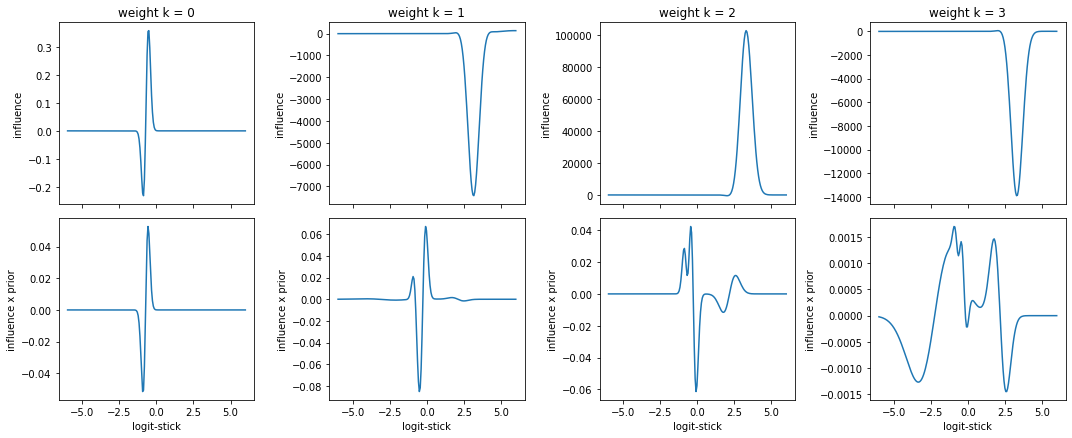

In [32]:
fig, ax = plt.subplots(2, 4, figsize = (15, 6),  sharex = True) 
for k in range(4): 
    ax[0, k].plot(logit_v_grid, e_num_ind_results['influence_grid{}'.format(k)])
    ax[0, k].set_title('weight k = {}'.format(k))
    ax[0, k].set_ylabel('influence')
    
    ax[1, k].plot(logit_v_grid, e_num_ind_results['influence_grid_x_prior{}'.format(k)])
    ax[1, k].set_ylabel('influence x prior')
    
    
fig.tight_layout();

for a in ax[1]: 
    a.set_xlabel('logit-stick')

### Influence function on expected number of clusters

In [33]:
prng_key = jax.random.PRNGKey(223)
threshold = 0

@jax.jit
def get_n_clusters_insample(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_num_clusters_from_vb_dict(iris_obs,
                                                    vb_params_dict,
                                                    gh_loc, gh_weights,
                                                    threshold = threshold,
                                                    n_samples = 10000, 
                                                    prng_key = prng_key)
@jax.jit
def get_n_clusters_pred(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_num_pred_clusters_from_vb_dict(vb_params_dict,
                                                               n_obs = iris_obs.shape[0],
                                                               threshold = threshold,
                                                               prng_key = prng_key)

In [34]:
infl_num_clust, infl_x_prior_num_clust, ghess_num_clust = \
    get_influence(get_n_clusters_insample)[0:3]
infl_num_clust_pred, infl_x_prior_num_clust_pred, ghess_num_clust_pred = \
    get_influence(get_n_clusters_pred)[0:3]

computing gradient ...
Elapsed: 7.690sec
inverting Hessian (twice) ...
Elapsed: 2.490sec
computing gradient ...
Elapsed: 1.545sec
inverting Hessian (twice) ...
Elapsed: 2.772sec


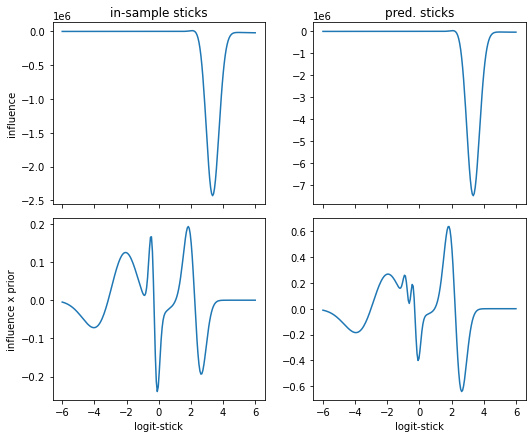

In [39]:
fig, ax = plt.subplots(2, 2, figsize = (7.5, 6), sharex = True) 

# Plot influence
ax[0, 0].set_title('in-sample sticks')
ax[0, 0].plot(logit_v_grid, infl_num_clust)
ax[0, 0].set_ylabel('influence')

ax[0, 1].set_title('pred. sticks')
ax[0, 1].plot(logit_v_grid, infl_num_clust_pred)

# plot influence x prior
ax[1, 0].plot(logit_v_grid, infl_x_prior_num_clust)
ax[1, 1].plot(logit_v_grid, infl_x_prior_num_clust_pred)
ax[1, 0].set_ylabel('influence x prior')

fig.tight_layout();

for a in ax[1]: 
    a.set_xlabel('logit-stick')

# Define step bumps

In [40]:
mu_vec = np.arange(-3, 6)

In [41]:
def step_bump(x, mu_indx):    
    return (x > mu_vec[mu_indx]) & (x <= mu_vec[mu_indx+1])


In [42]:
# analytic expectations since we are just perturbing with step functions

def e_step_bump(means, infos, mu_indx): 
    cdf1 = sp.stats.norm.cdf(mu_vec[mu_indx+1], loc = means, scale = 1 / np.sqrt(infos))
    cdf2 = sp.stats.norm.cdf(mu_vec[mu_indx], loc = means, scale = 1 / np.sqrt(infos))
    
    return (cdf1 - cdf2).sum()


# Function to load refits

In [43]:
def _load_refit_results_for_mu(g, mu_indx): 
    match_crit = out_filename + '_inflbump_mu{}_eps'.format(mu_indx) + '\d+.npz'
    
    # load free parameters
    vb_refit_list, epsilon_vec, meta_data_list = \
        result_loading_utils.load_refit_files_epsilon(out_folder, match_crit)

    # check mu's match
    assert np.all(result_loading_utils._load_meta_data_from_list(meta_data_list, 'mu') == \
                  mu_vec[mu_indx])
    
    # check prior parameter matches
    assert np.all(result_loading_utils._load_meta_data_from_list(meta_data_list, 'dp_prior_alpha') == \
                  alpha0)
    
    refit_g_vec = np.array([g(x) for x in vb_refit_list])
    
    return refit_g_vec, epsilon_vec

In [44]:
def load_refit_results(g): 
        
    for j in range(6): 
        # load results from particular mu
        refit_g_vec, epsilon_vec = \
            _load_refit_results_for_mu(g, j)
        
        if j == 0: 
            # initialize
            refit_g_array = onp.zeros((len(mu_vec), len(epsilon_vec)))
            _epsilon_vec = epsilon_vec
            
        refit_g_array[j] = refit_g_vec
        
        assert np.all(_epsilon_vec == epsilon_vec)
        
    return refit_g_array, epsilon_vec


# Compute cross-hessians

One cross-hessian for each mu

In [45]:
cross_hess_list = []

for i in range(len(mu_vec) - 1): 
    # compute linear response stuff
    f_obj = func_sens_lib.FunctionalPerturbationObjective(None, 
                                                          vb_params_paragami, 
                                                          e_log_phi = lambda x,y : e_step_bump(x,y,i), 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')

    vb_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)
    
    cross_hess_list.append(vb_sens.cross_hess.squeeze())


Compiling cross hessian...
Cross-hessian compile time: 0.592665sec

LR sensitivity time: 0.0148072sec

Compiling cross hessian...
Cross-hessian compile time: 0.480838sec

LR sensitivity time: 0.0136485sec

Compiling cross hessian...
Cross-hessian compile time: 0.48018sec

LR sensitivity time: 0.0162733sec

Compiling cross hessian...
Cross-hessian compile time: 0.479848sec

LR sensitivity time: 0.0162361sec

Compiling cross hessian...
Cross-hessian compile time: 0.48157sec

LR sensitivity time: 0.0143156sec

Compiling cross hessian...
Cross-hessian compile time: 0.481912sec

LR sensitivity time: 0.0143125sec

Compiling cross hessian...
Cross-hessian compile time: 0.483294sec

LR sensitivity time: 0.0147378sec

Compiling cross hessian...
Cross-hessian compile time: 0.48287sec

LR sensitivity time: 0.0146987sec



# Function to get LR derivatives for a given posterior statistic

In [46]:
def get_lr_results(g, ghess, epsilon_vec):
    lr_g_array = onp.zeros((len(mu_vec), len(epsilon_vec)))

    for i in range(len(mu_vec) - 1): 

        # derivative of posterior quantity wrt hyper parameter
        # note the negative sign!
        # the "cross-hessian" is computed using the perturbation to the KL!
        # to get the derivative, we need the inner-product between 
        # the influence operator and the perturbation to the **ELBO**
        # see theorem 2 in giordano
        dg_dhyper = np.dot(ghess, -cross_hess_list[i])
        
        # get lr results
        lr_g_array[i, :] = g(vb_opt) + dg_dhyper * epsilon_vec
    
    return lr_g_array


# Plot results

In [109]:
def p0(logit_v): 
    return np.exp(influence_lib.get_log_logitstick_prior(logit_v, alpha0))

In [110]:
def plot_results(g, ghess, influence_grid, influence_x_prior_grid): 
    
    # get array of posterior values
    refit_g_array, epsilon_vec = load_refit_results(g)

    # lr results
    lr_g_array = get_lr_results(g, 
                                ghess, 
                                epsilon_vec)
    
    fig, ax = plt.subplots(nrows=3, ncols=len(mu_vec) - 1, figsize = (18, 6), sharex = 'col', sharey='row')
    fig2, ax2 = plt.subplots(1, len(mu_vec) - 1, figsize = (18, 3), sharey=True)
    
    x = np.linspace(-6, 6, 1000)
    
    infl_scale = np.abs(influence_grid).max()
    
    for i in range(len(mu_vec) - 1): 
        
        # plot prior 
        ax[0, i].plot(x, p0(x))
        
        # plot influence function
        ax[1, i].plot(logit_v_grid, influence_grid)
        
        # plot prior x influence function 
        ax[2, i].plot(logit_v_grid, influence_x_prior_grid)
        # plot y = 0
        ax[2, i].axhline(0, color = 'black')
                
        # overlay bump
        # plot(x, step_bump(x, i), color = 'grey')
        for j in range(3):
            ax[j, i].axvline(mu_vec[i], color = 'grey', linestyle = '--')
            ax[j, i].axvline(mu_vec[i+1], color = 'grey', linestyle = '--')

        
        ax[-1, i].set_xlabel('logit stick')

        
        # plot refit results
        ax2[i].plot(epsilon_vec,
                      refit_g_array[i, :] - refit_g_array[i, 0], 
                      '-o', 
                      label = 'refit')

        # plot lr results
        ax2[i].plot(epsilon_vec, 
                      lr_g_array[i, :] - lr_g_array[i, 0], 
                      '-o', 
                      label = 'lr')
        ax2[i].set_xlabel('epsilon')
        ax2[i].axhline(0, color = 'black')
        
    
    ax[0, 0].set_ylabel('prior')
    ax[1, 0].set_ylabel('infl')
    ax[2, 0].set_ylabel('infl x prior')

    ax2[0].legend()
    ax2[0].set_ylabel('g')
    
    fig.tight_layout()
    fig2.tight_layout()
    

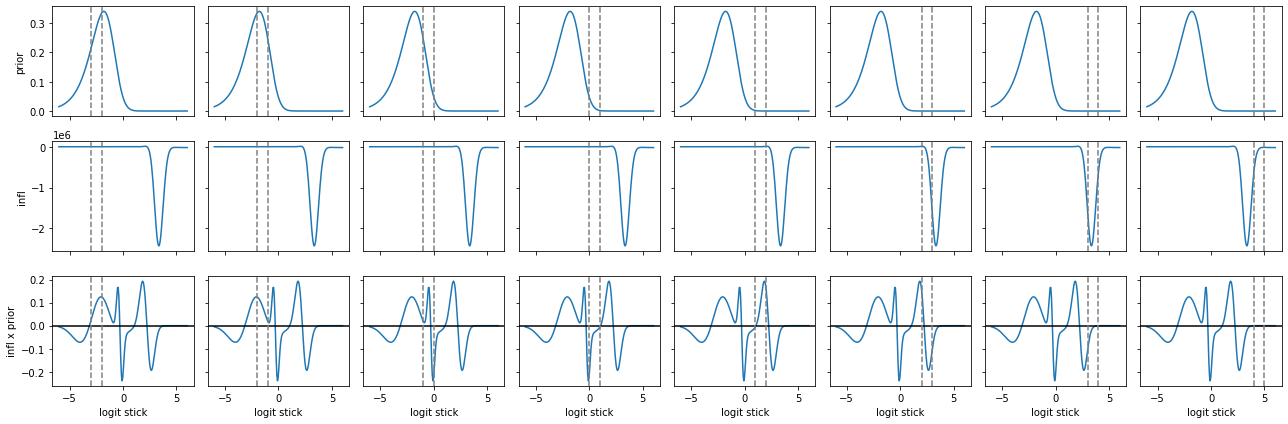

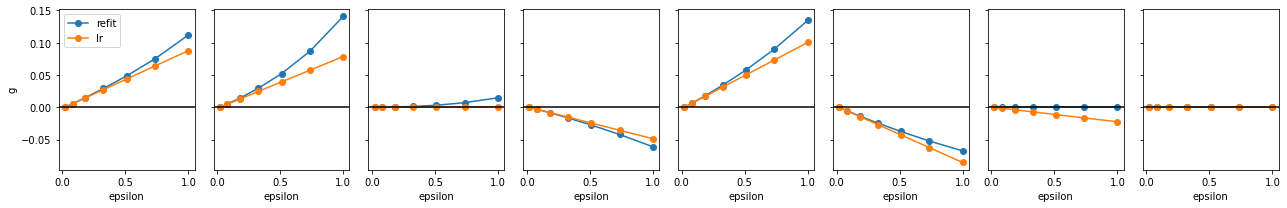

In [111]:
plot_results(get_n_clusters_insample,
                 ghess_num_clust, 
                 infl_num_clust,
                 infl_x_prior_num_clust)


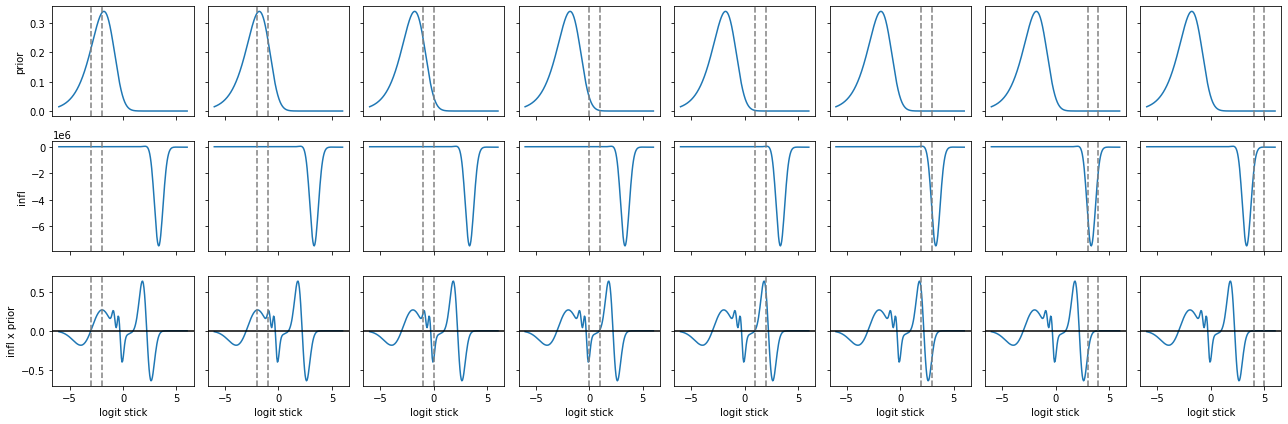

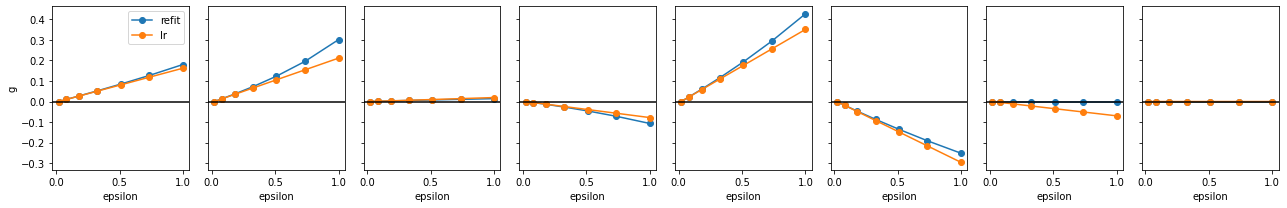

In [112]:
plot_results(get_n_clusters_pred,
                 ghess_num_clust_pred, 
                 infl_num_clust_pred,
                 infl_x_prior_num_clust_pred)


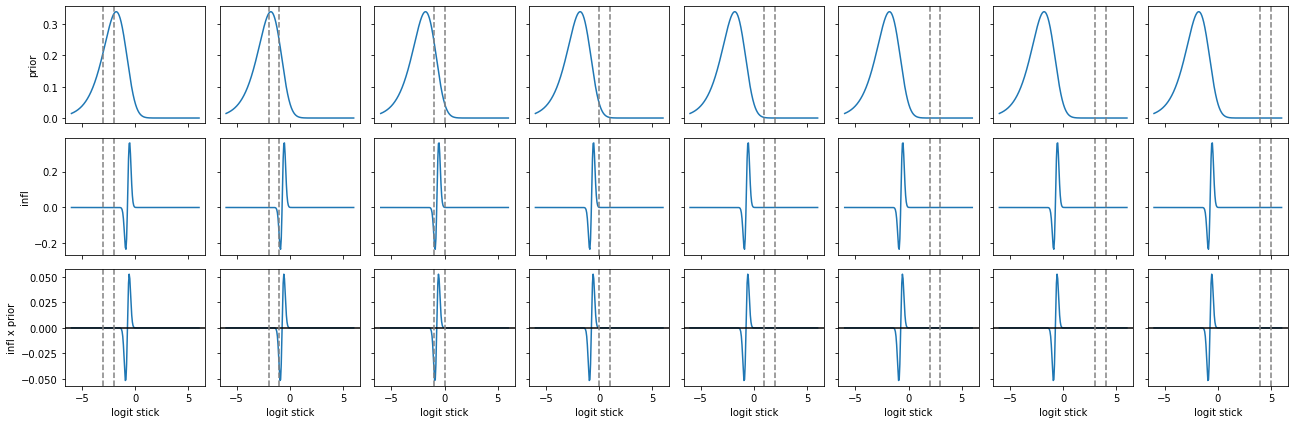

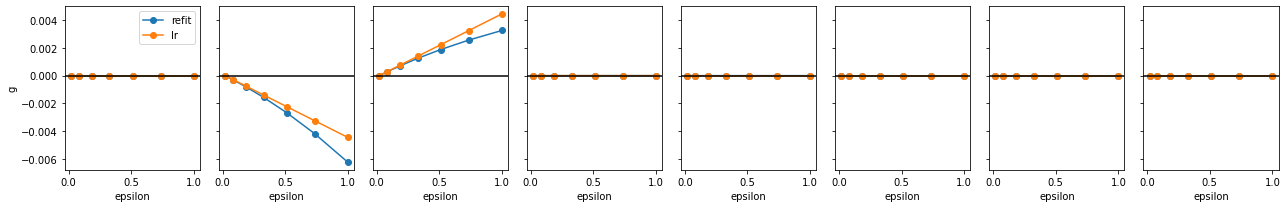

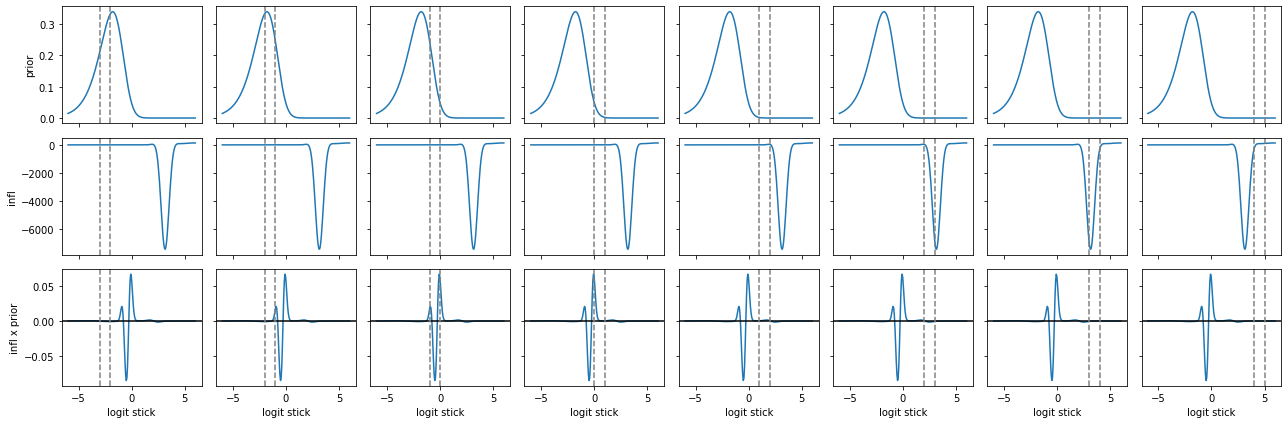

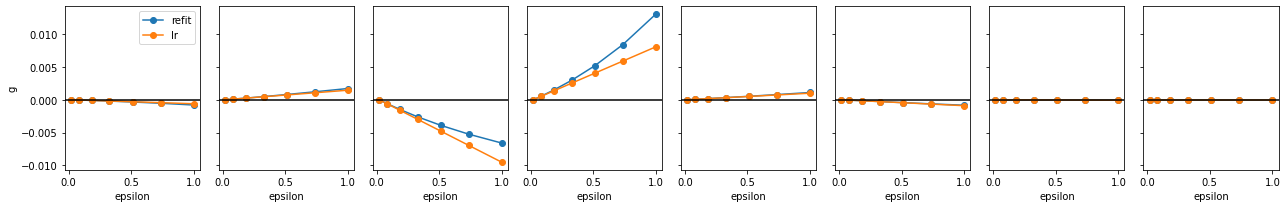

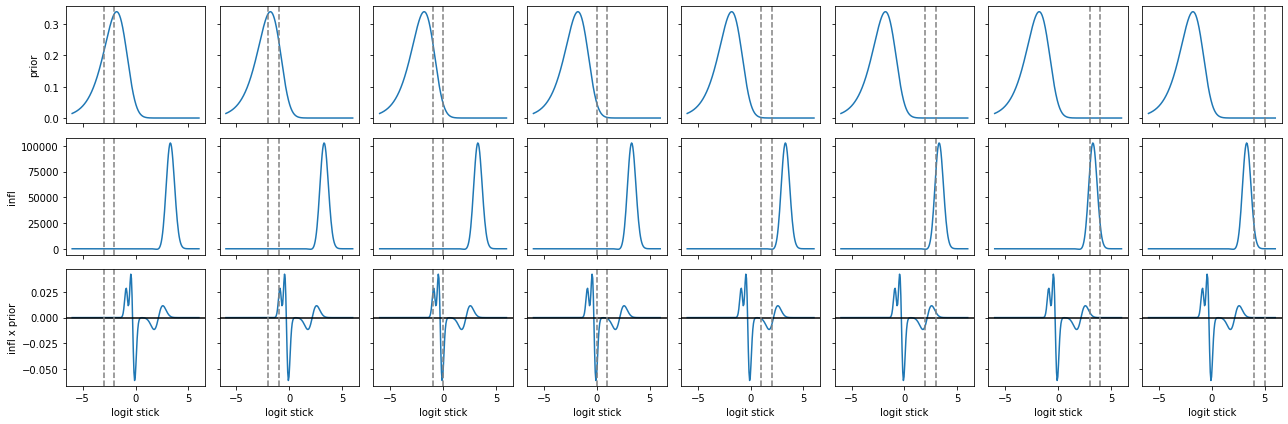

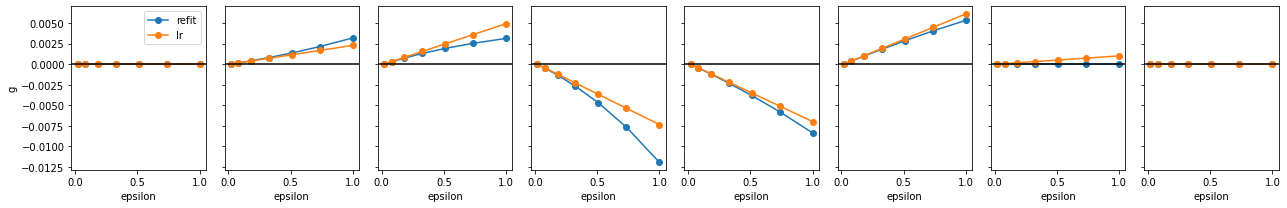

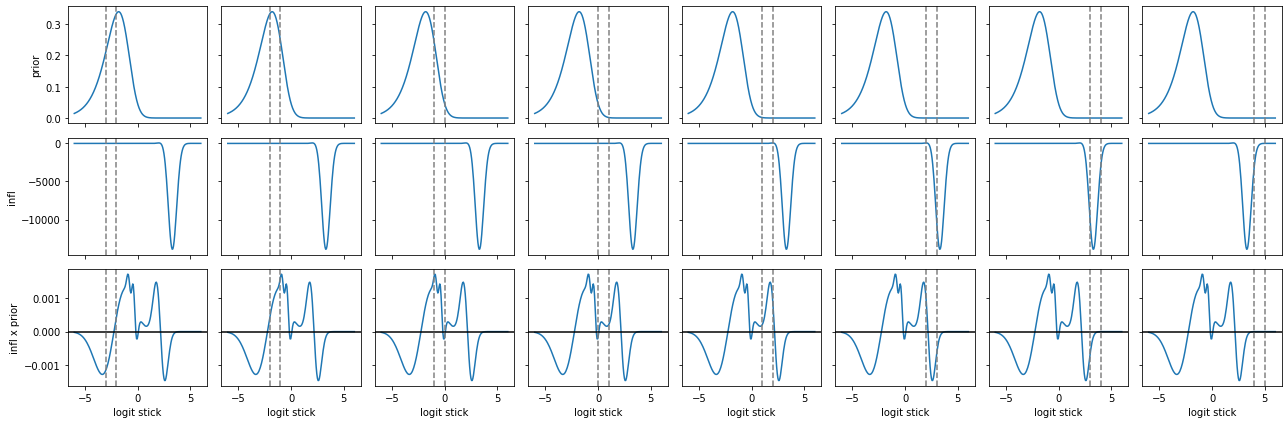

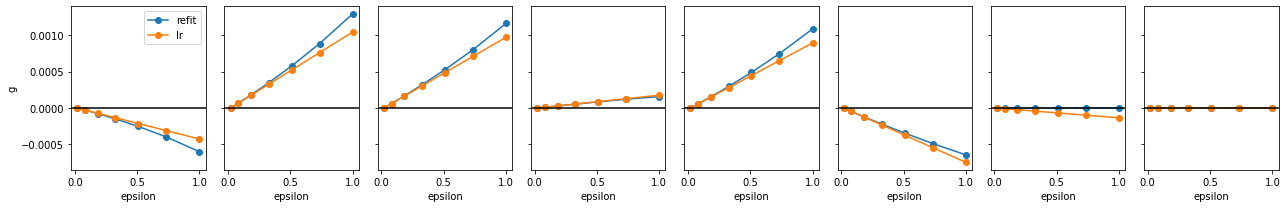

In [113]:
for k in range(4): 
    plot_results(lambda x : get_mixture_weight_k(x, k), 
                     e_num_ind_results['ghess{}'.format(k)], 
                     e_num_ind_results['influence_grid{}'.format(k)], 
                     e_num_ind_results['influence_grid_x_prior{}'.format(k)])
